# Optimizing Portfolio

In [15]:
%matplotlib inline

import numpy as np
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy.stats import norm
import pylab as plt


In [16]:
import sys
sys.path.append('C:\\projects\\finances.git\\finances')

from finances.market import market_data as mkt_data

In [17]:
mkt=mkt_data.MarketData()
returns_data = mkt.crypto_returns_data(
    symbols=['ADA', 'BTC', 'ETH', 'XLM', 'XRP', 'TRX', 'LTC','NEO', 'DASH'],
    time_step='1D',
).dropna()
returns_data.head()

Loaded crypto currency database from C:\projects\finances.git\finances\market\data_base\crypto_currencies\main_crypto_eur_database.csv


,ADA,BTC,ETH,XLM,XRP,TRX,LTC,NEO,DASH
2017-10-04,0.050526,-0.023236,-0.002203,-0.047262,0.053298,0.324326,-0.020979,-0.075569,0.028149
2017-10-05,-0.016399,0.027342,0.014808,0.234652,0.107789,0.025453,0.009105,0.039914,0.003635
2017-10-06,-0.134700,0.012815,0.046145,0.266330,-0.009608,-0.094892,0.011725,0.041518,0.007850
2017-10-07,0.129565,0.012831,0.008199,0.138890,0.019531,-0.179239,0.008826,0.078162,0.011764
2017-10-08,-0.022157,0.041472,-0.008068,-0.112649,0.173228,0.028874,0.010650,-0.112618,-0.025798


## Estimate distributions

In [34]:
n_days =30
projected_returns = pd.DataFrame()
for r in returns_data:
    rets = returns_data[r]
    
    # MLE of the sample for a normal distribution (to be improved) 
    daily_mu, daily_std = norm.fit(rets)
    monthly_mu, monthly_std = n_days*daily_mu, daily_std*np.sqrt(n_days)
    print(monthly_mu, monthly_std)

    # generate big sample with the monthly distribution
    monthly_data = norm.rvs(monthly_mu, monthly_std, size=1000)
    
    #add that as new returns for the month
    projected_returns[r] = monthly_data

1.11525102823 1.08103816444
0.215236953676 0.342468789367
0.322398046832 0.340534139765
1.1563282136 0.872482252662
0.566149284527 0.741250754836
1.19429203994 1.19714927706
0.320780883831 0.49716722213
0.418758757885 0.51632779061
0.254826779133 0.477816052043


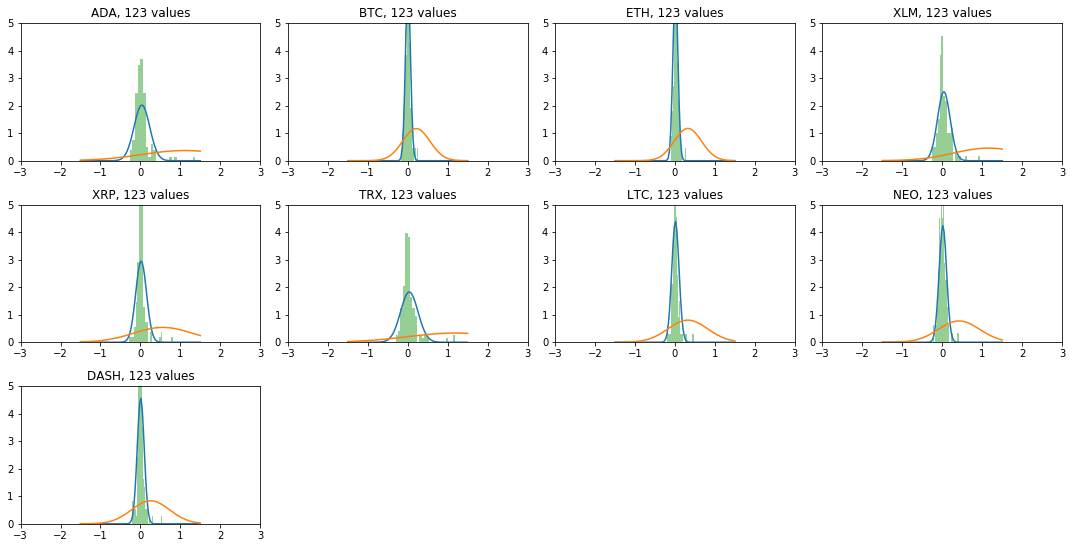

In [35]:
x = np.linspace(-1.5,1.5,100)
# get the pdf of the variables

fig = plt.figure(figsize=(15,10))
f = 1
for r in returns_data.columns:
    rets = returns_data[r]
    daily_mu, daily_std = norm.fit(rets)
    monthly_mu, monthly_std = n_days*daily_mu, daily_std*np.sqrt(n_days)
    
    # get pdf
    p_daily = norm.pdf(x, daily_mu, daily_std)
    p_monthly = norm.pdf(x, monthly_mu, monthly_std)

    # create the figures
    fig.add_subplot(4,4,f)
    ax = plt.gca()
    plt.plot(x, p_daily, label='Daily')
    plt.plot(x, p_monthly, label='Monthly')
    plt.hist(rets, bins=25, normed=True, alpha=0.5)
    f+=1
    ax.set_title('{}, {} values'.format(r, len(rets)))
    ax.set_ylim(0,5)
    ax.set_xlim(-3,3)
plt.tight_layout()

## Calculate Markowitz frontier

In [36]:
from math import sqrt
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp, options

import portfolioopt as pfopt

In [37]:
avg_rets = projected_returns.mean()
cov_mat = projected_returns.cov()
avg_rets

ADA     1.123905
BTC     0.207638
ETH     0.318774
XLM     1.178267
XRP     0.557405
TRX     1.169286
LTC     0.334663
NEO     0.410832
DASH    0.261973
dtype: float64

In [38]:
# calculate the Markowitz optimal allocations for each target return value
optimal_allocation_list = []
for k in np.arange(0.01,0.99, 0.01):
    tgt_return = avg_rets.quantile(k)
    optimal_weights = pfopt.markowitz_portfolio(cov_mat=cov_mat, exp_rets=avg_rets, target_ret=tgt_return)
    optimal_allocation_list.append(optimal_weights)


In [39]:
optimal_allocation_list[0]

ADA     0.027593
BTC     0.252464
ETH     0.245422
XLM     0.036876
XRP     0.055487
TRX     0.023811
LTC     0.127267
NEO     0.102068
DASH    0.129012
dtype: float64

In [40]:
matrix_rets = avg_rets.as_matrix()
matrix_cov = cov_mat.as_matrix()
returns = [x.dot(matrix_rets) for x in optimal_allocation_list]
risks = [sqrt(x.dot(matrix_cov.dot(x))) for x in optimal_allocation_list]

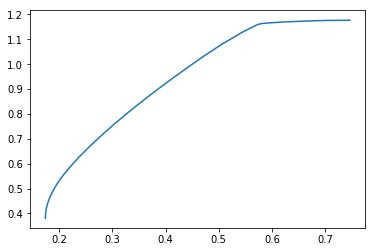

In [41]:
plt.plot(risks, returns)

In [152]:
pfopt.markowitz_portfolio(cov_mat=cov_mat, exp_rets=avg_rets, target_ret=0.6)

ADA    0.029724
BTC    0.352178
ETH    0.303077
XLM    0.054047
XRP    0.073414
TRX    0.034975
LTC    0.152586
dtype: float64